# Classification Tree Tutorial  
In this notebook, we'll train and evaluate a ClassificationTree model on a sample dataset

We'll start by loading a dataset; in this case, the infamous golf dataset to predict if a given day has the adequate climate to play golf.

In [ ]:
%load_ext autoreload 
%autoreload 2

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import sklearn.datasets

def read_classification_dataset(url:str):
    df = pd.read_csv(url)
    x = df.iloc[:,:-1]
    le = LabelEncoder().fit(df.iloc[:,-1])
    y = le.transform(df.iloc[:,-1])
    y = y.reshape(len(y),1)
    return x,y,le.classes_

dataset_name="golf_classification"
url = "https://raw.githubusercontent.com/facundoq/facundoq.github.io/refs/heads/master/datasets/classification/golf_classification_numeric.csv"
x,y,class_names = read_classification_dataset(url)

print(x)
print(y.shape)
print(class_names)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
    Ambiente  Temperatura  Humedad Viento
0    soleado           85       85     NO
1    soleado           80       90     SI
2    nublado           83       86     NO
3   lluvioso           70       96     NO
4   lluvioso           68       80     NO
5   lluvioso           65       70     SI
6    nublado           64       65     SI
7    soleado           72       95     NO
8    soleado           69       70     NO
9   lluvioso           75       80     NO
10   soleado           75       70     SI
11   nublado           72       90     SI
12   nublado           81       75     NO
13  lluvioso           71       91     SI
(14, 1)
['No' 'Si']


# Model definition
To define our model, we must first create a `TreeTrainer` object. This object will actually take care of the training process for the `Tree` when we call `predict`. The `TreeTrainer` requires some configuration: a `GlobalError` object that can evaluate columns on each split, and a `PruneCriteria` to know then to stop growing the tree.

In this case, we are using the `MixedGlobalError`, with different column splitters for nominal and numeric attributes. In the case of the numeric columns, the `DiscretizingNumericColumnSplitter` with the `OptimizingDiscretizationStrategy` will look for the best binary discretization of each numeric attribute on each split.

Additionally, the `MixedGlobalError` uses an `EntropyMetric` error to evaluate the predictions of the tree; this can be replaced with a `GiniIndex` or any other custom error metric.

In [ ]:
from sklearnmodels import tree

def get_model(classes:int):
    numeric_discretization_strategy = tree.OptimizingDiscretizationStrategy(max_evals=30)
    column_errors = {
        "number":tree.DiscretizingNumericColumnSplitter(numeric_discretization_strategy),
        "object":tree.NominalColumnSplitter(),
        "bool":tree.NominalColumnSplitter()
    }
    global_error = tree.MixedGlobalError(column_errors,tree.EntropyMetric(classes))
    prune_criteria = tree.PruneCriteria(max_height=5,min_samples_leaf=2,min_error_improvement=0.01)
    trainer = tree.BaseTreeTrainer(global_error,prune_criteria)
    model = tree.SKLearnClassificationTree(trainer)
    return model


# Training and evaluation

To make this short, we'll both train and evaluate on the train set using the typical `fit` and `predict` methods. This is no different than with any other `scikit-learn` models.

In [14]:
from sklearn.metrics import accuracy_score

model = get_model(len(class_names))

model.fit(x,y)
y_pred = model.predict(x)
print(f"Dataset {dataset_name:40} accuracy: {accuracy_score(y,y_pred)*100:.2f}%")


Dataset golf_classification_nominal              accuracy: 71.43%


# Visualization
Finally, we'll want to visualize our trained tree. We have to choices: a plain text pretty printing of the tree (`Tree.pretty_print()`), or a full blown `graphviz` graph (`tree.export_dot(...)`).

In both cases, well have to grab the `tree` property from our `model`, that holds the actual tree.

In [15]:
print(model.tree.pretty_print())

root
|   🪵Ambiente=soleado => 
|   |   🪵Humedad > 70 => 🍁([1. 0.],n=3)
|   🪵Ambiente=nublado => 🍁([0. 1.],n=4)
|   🪵Ambiente=lluvioso => 
|   |   🪵Viento=NO => 🍁([0. 1.],n=3)


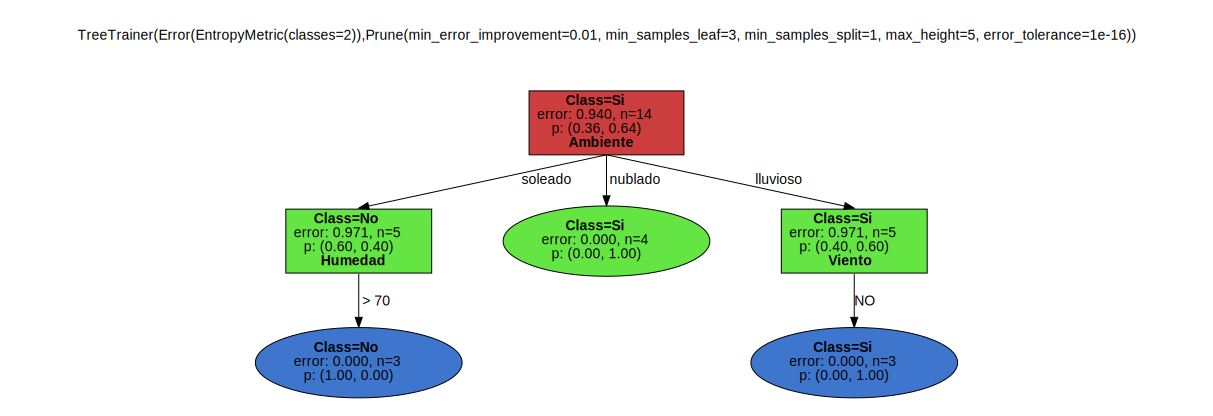

In [16]:
import graphviz 
dot_graph = tree.export_dot(model.tree,title=f"{model.trainer}",class_names=class_names)
graphviz.Source(dot_graph)
